In [1]:
%pip install coinmetrics-api-client -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.1 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
import pandas as pd
from coinmetrics.api_client import CoinMetricsClient

api_key = userdata.get('api_key')
client = CoinMetricsClient(api_key)


Let's figure out the assets that trade on Coinbase.

In [45]:
catalog = client.catalog_market_orderbooks_v2(exchange='coinbase', market_type='spot').to_dataframe()
catalog

,market,depth,min_time,max_time
0,coinbase-00-usd-spot,30000,2023-07-26 13:00:00+00:00,2025-02-20 11:00:00+00:00
1,coinbase-1inch-btc-spot,30000,2021-08-20 13:00:00+00:00,2025-01-31 17:00:00+00:00
2,coinbase-1inch-eur-spot,30000,2021-08-20 13:00:00+00:00,2025-02-20 11:00:00+00:00
3,coinbase-1inch-gbp-spot,30000,2021-08-20 13:00:00+00:00,2025-02-20 11:00:00+00:00
4,coinbase-1inch-usd-spot,100,2022-08-04 21:14:30+00:00,2025-02-20 11:59:10+00:00
...,...,...,...,...
727,coinbase-zrx-btc-spot,30000,2021-08-20 13:00:00+00:00,2023-10-16 19:00:00+00:00
728,coinbase-zrx-eur-spot,30000,2021-08-20 13:00:00+00:00,2023-10-16 19:00:00+00:00
729,coinbase-zrx-usd-spot,100,2021-07-17 11:21:30+00:00,2025-02-20 11:59:20+00:00
729,coinbase-zrx-usd-spot,10pct_mid_price,2022-10-19 19:00:00+00:00,2025-02-20 11:59:20+00:00


In [46]:
catalog.loc[(catalog.max_time>'2025-02-01')].groupby('market').size().sort_values(ascending=False)

,0
market,
coinbase-zrx-usd-spot,3
coinbase-grt-usd-spot,3
coinbase-snx-usd-spot,3
coinbase-bnt-usd-spot,3
coinbase-sol-usd-spot,3
...,...
coinbase-etc-eur-spot,1
coinbase-etc-btc-spot,1
coinbase-ern-usd-spot,1


In [47]:
catalog.loc[catalog.market=='coinbase-sol-usd-spot']

,market,depth,min_time,max_time
593,coinbase-sol-usd-spot,100,2022-08-04 21:14:50+00:00,2025-02-20 11:59:20+00:00
593,coinbase-sol-usd-spot,10pct_mid_price,2022-10-19 19:00:00+00:00,2025-02-20 11:59:20+00:00
593,coinbase-sol-usd-spot,30000,2021-08-20 13:00:00+00:00,2025-02-20 11:00:00+00:00


In [93]:
t = pd.Timestamp.now() - pd.Timedelta(hours=2)

ob_30000 = client.get_market_orderbooks(
    markets=['coinbase-sol-usd-spot'],
    granularity='raw',
    page_size=100,
    start_time=t,
    depth_limit='30000'
).to_list()
ob_30000[-1]['time']

'2025-02-20T12:00:00.000000000Z'

In [94]:
asks = pd.DataFrame(ob_30000[-1]['asks'])
asks['price'] = pd.to_numeric(asks['price'])
asks['size'] = pd.to_numeric(asks['size'])
asks

,price,size
0,173.98,3.780311
1,173.99,0.975103
2,174.00,8.623800
3,174.01,31.664626
4,174.02,43.098936
...,...,...
10573,1970.00,4.019171
10574,1999.00,10.000000
10575,3998.00,3.000000
10576,4000.00,4.000000


In [95]:
mid_price = (pd.to_numeric(ob_30000[-1]['asks'][0]['price']) + pd.to_numeric(ob_30000[-1]['bids'][0]['price']))/2
mid_price

173.975

In [96]:
# how many asks fall within 10% of the mid price?
asks[asks['price']<(mid_price*1.1)]


,price,size
0,173.98,3.780311
1,173.99,0.975103
2,174.00,8.623800
3,174.01,31.664626
4,174.02,43.098936
...,...,...
1209,191.32,0.528323
1210,191.33,0.134420
1211,191.34,0.000002
1212,191.36,1.578112


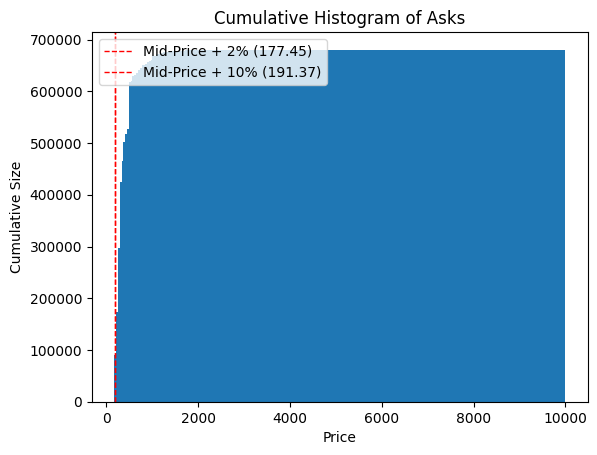

In [97]:
import matplotlib.pyplot as plt

# Calculate the price level for the vertical line
vertical_line_price = (mid_price * 1.02, mid_price * 1.1)

# Create the histogram with cumulative size
plt.hist(asks['price'], weights=asks['size'], bins=250, cumulative=True)

# Add the vertical line
plt.axvline(vertical_line_price[0], color='red', linestyle='dashed', linewidth=1, label=f'Mid-Price + 2% ({vertical_line_price[0]:.2f})')
plt.axvline(vertical_line_price[1], color='red', linestyle='dashed', linewidth=1, label=f'Mid-Price + 10% ({vertical_line_price[1]:.2f})')

# Customize the plot
plt.xlabel('Price')
plt.ylabel('Cumulative Size')
plt.title('Cumulative Histogram of Asks')
plt.legend()  # Show the legend for the vertical line
plt.show()


In [98]:
# 2 minutes ago
t = pd.Timestamp.now() - pd.Timedelta(minutes=2)


ob_10p = client.get_market_orderbooks(
    markets=['coinbase-sol-usd-spot'],
    granularity='raw',
    page_size=100,
    start_time=t,
    depth_limit='10pct_mid_price'
).to_list()

print(f'Last available data: {ob_10p[-1]["time"]}')

asks = pd.DataFrame(ob_10p[-1]['asks'])
print(f"Size: {asks.shape[-1]}")
asks['price'] = pd.to_numeric(asks['price'])
asks['size'] = pd.to_numeric(asks['size'])

asks



Last available data: 2025-02-20T12:46:40.000000000Z
Size: 2


,price,size
0,173.97,66.664101
1,173.99,8.410831
2,174.00,43.930091
3,174.01,96.891441
4,174.02,142.157960
...,...,...
1210,191.30,0.153533
1211,191.32,0.528323
1212,191.33,0.134420
1213,191.34,0.000002


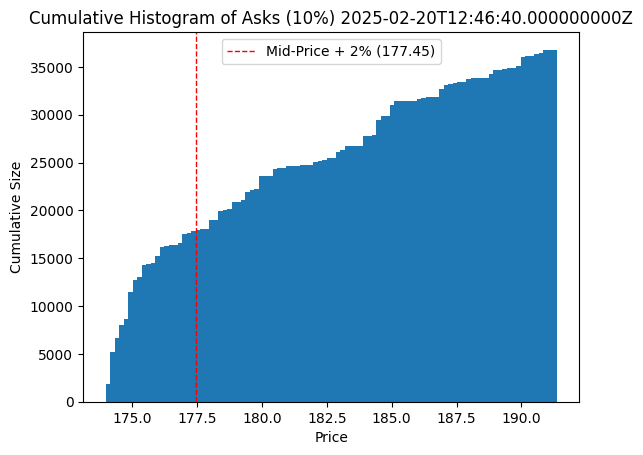

In [99]:
# Create the histogram with cumulative size
plt.hist(asks.loc[:, 'price'], weights=asks.loc[:, 'size'], bins=100, cumulative=True)

# Add the vertical line
plt.axvline(vertical_line_price[0], color='red', linestyle='dashed', linewidth=1, label=f'Mid-Price + 2% ({vertical_line_price[0]:.2f})')


# Customize the plot
plt.xlabel('Price')
plt.ylabel('Cumulative Size')
plt.title(f'Cumulative Histogram of Asks (10%) {ob_10p[-1]["time"]}')
plt.legend()  # Show the legend for the vertical line

plt.show()


In [100]:
import asyncio
import websockets
import nest_asyncio

# Apply nest_asyncio to allow nested event loops
nest_asyncio.apply()

orderbook_from_stream = []

async def handle(uri):
    go = True
    async with websockets.connect(uri) as websocket:
        while go:
            orderbook_from_stream.append(await websocket.recv())
            go = False

url = f'wss://api.coinmetrics.io/v4/timeseries-stream/market-orderbooks'\
f'?markets=coinbase-sol-usd-spot'\
f'&depth_limit=full_book'\
f'&api_key={api_key}'

asyncio.run(handle(url))

len(orderbook_from_stream)

1

In [101]:
asks = pd.DataFrame(json.loads(orderbook_from_stream[0])['asks'])
asks['price'] = pd.to_numeric(asks['price'])
asks['size'] = pd.to_numeric(asks['size'])

filtered = asks[asks['price']<(mid_price*1.1)]

asks

,price,size
0,173.75,4.748839
1,173.76,11.510220
2,173.77,1.542535
3,173.78,64.975959
4,173.79,158.396464
...,...,...
10580,1970.00,4.019171
10581,1999.00,10.000000
10582,3998.00,3.000000
10583,4000.00,4.000000


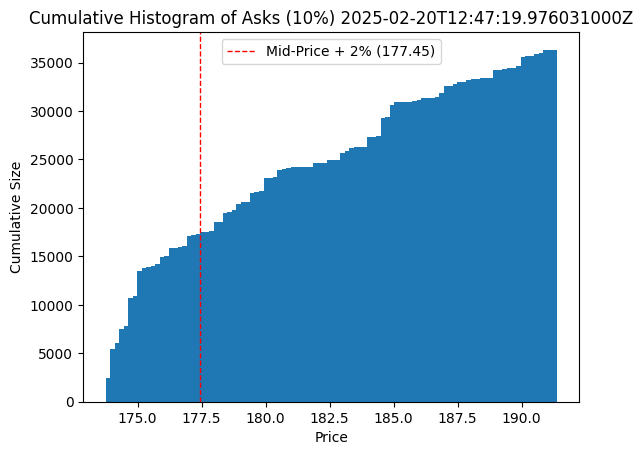

In [102]:
# Create the histogram with cumulative size
plt.hist(filtered['price'], weights=filtered['size'], bins=100, cumulative=True)

# Add the vertical line
plt.axvline(vertical_line_price[0], color='red', linestyle='dashed', linewidth=1, label=f'Mid-Price + 2% ({vertical_line_price[0]:.2f})')


# Customize the plot
plt.xlabel('Price')
plt.ylabel('Cumulative Size')
plt.title(f'Cumulative Histogram of Asks (10%) {json.loads(orderbook_from_stream[0])["time"]}')
plt.legend()  # Show the legend for the vertical line

plt.show()
